# Introduction

In this notebook I am working on creating the MP-Iteration in 1D. This is the current implementation:

Loop over the parameter $\beta$ $(\beta += 10, 0 \leq \beta \leq 100)$

1. Physical solve for $-u’’= f$ where f is $-u’’$ for $u = \arctan(\beta x)$ and $x$ is the spatial coordinate of a uniform mesh

2. Linear Mesh Solve based on Classic HR

3. Nonlinear Mesh Solve Iteration based on Classic HR

  - Set $u_{interp} = \arctan(\beta x_{uniform})$.
    Set $x_{old}$ as a uniform mesh.

  - Iterate n=? times

    a. Compute the first derivative of $u_{interp}$ for $M$

    b. $u_{pr} = 1/J_{x}$ $u_{interp}.dx(0)$ where $J_{x} = $d(x_{old})/d\xi$ )

    c. Compute $M$ as a function of $u_{pr}$
    - M depends on derivatives of $u_{interp}($x_{old})$

    d. Solve the mesh problem for xnew where $M$ is a function of $u_{interp}(x_{old})$

    e. Update u_interp and $x_{old}$ based on the mesh solution




November 2024, January and February 2025

# Imports

In [1]:
# install firedrake

# hide output
%%capture

try:
    import firedrake
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/firedrake-install-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
    import firedrake

In [2]:
# Code in this cell makes plots appear an appropriate size and resolution in the browser window

%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (11, 6)

In [3]:
# import firedrake tools

from firedrake import *
import numpy as np
import matplotlib.pyplot as plt # firedrake makes use of matplotlib tools
from firedrake.pyplot import tripcolor, tricontour, triplot #firedrake plotting
from IPython.display import display
from mpl_toolkits import mplot3d



# Physical Solve and M Computation On Uniform Mesh


____________________________________________________________________________________________________

beta =  5

____________________________________________________________________________________________________



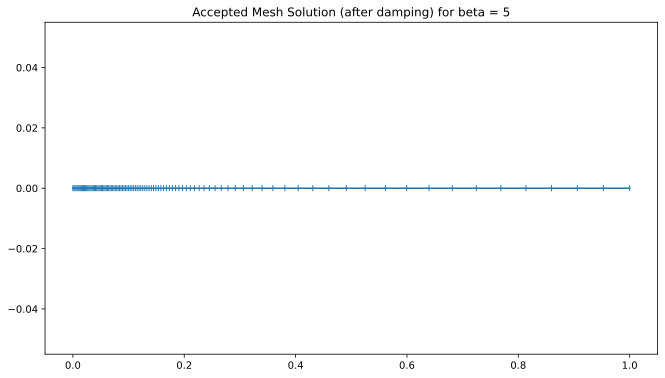

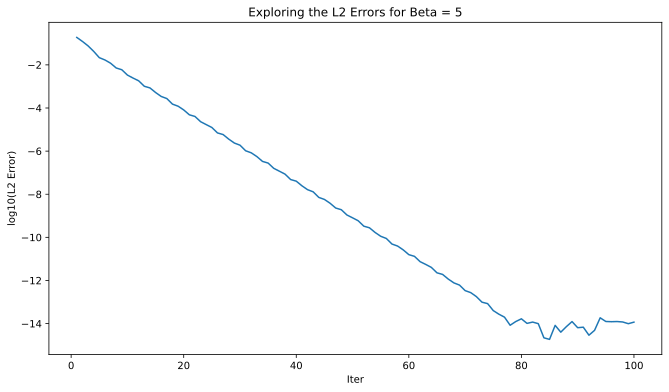

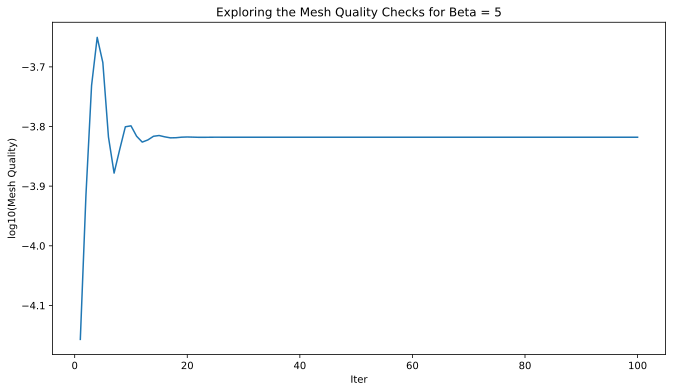



____________________________________________________________________________________________________

beta =  10

____________________________________________________________________________________________________



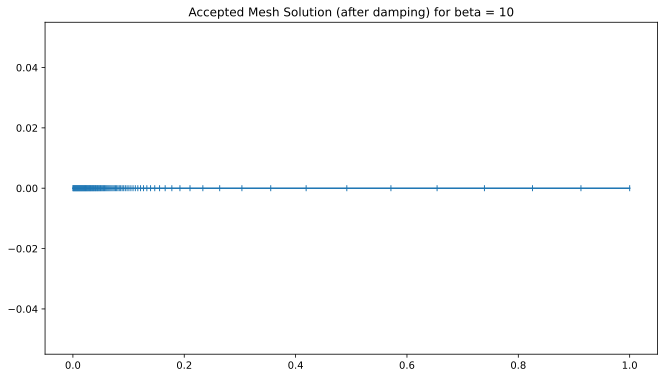

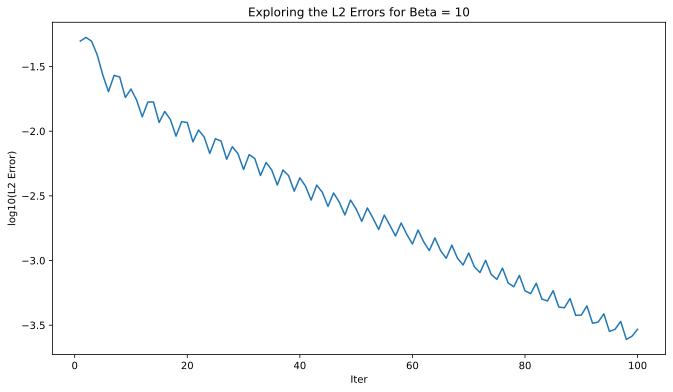

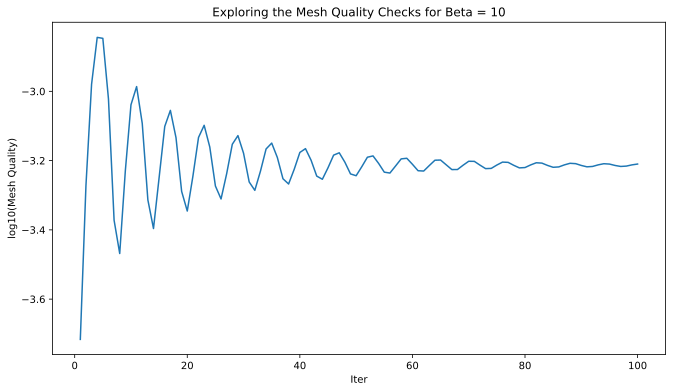



____________________________________________________________________________________________________

beta =  15

____________________________________________________________________________________________________



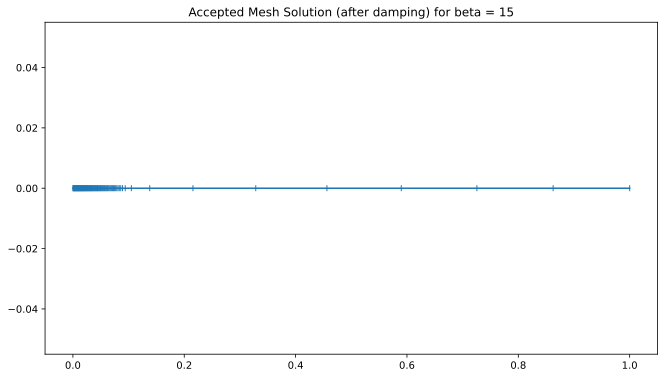

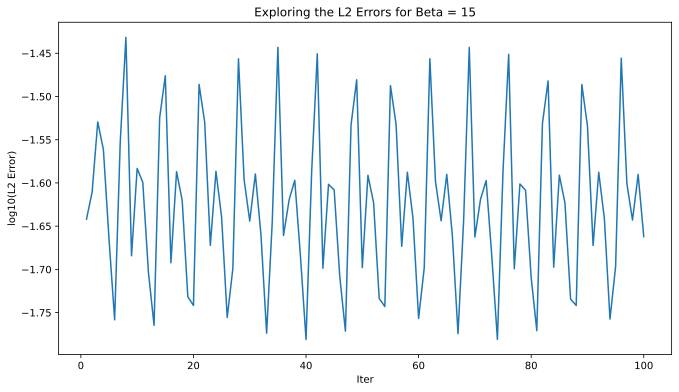

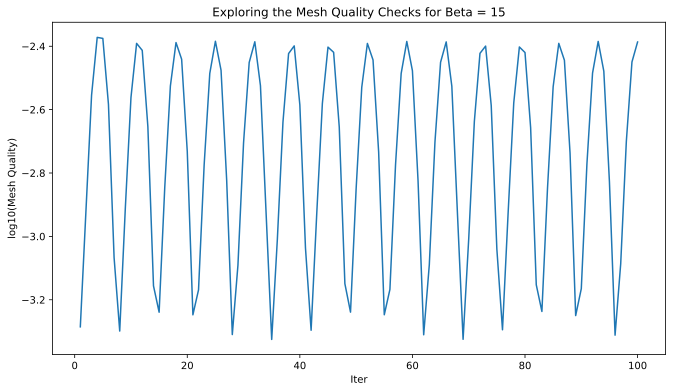



____________________________________________________________________________________________________

beta =  20

____________________________________________________________________________________________________



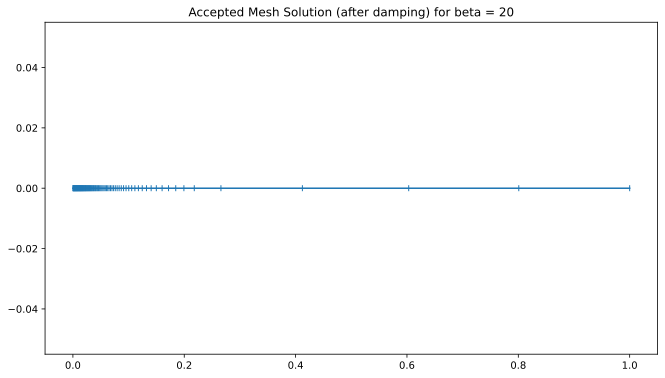

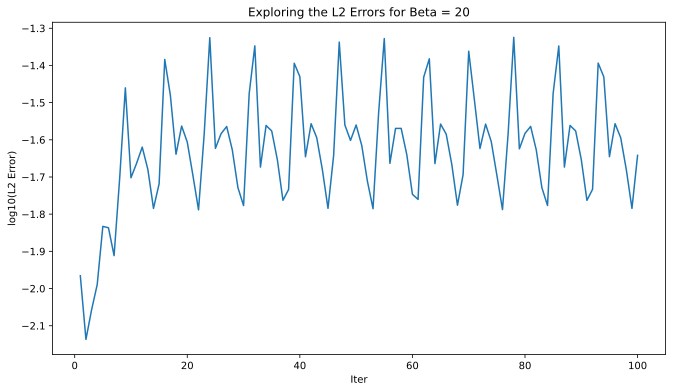

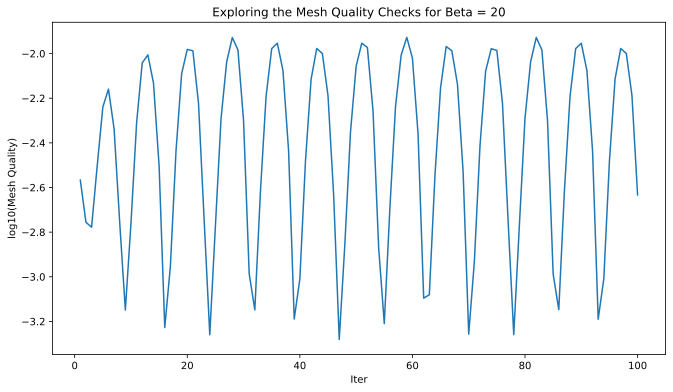



____________________________________________________________________________________________________

beta =  25

____________________________________________________________________________________________________



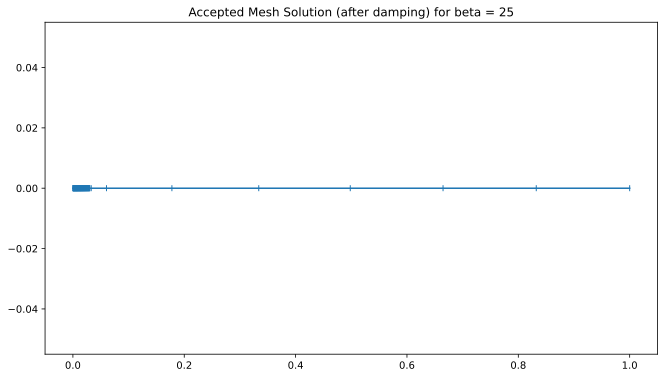

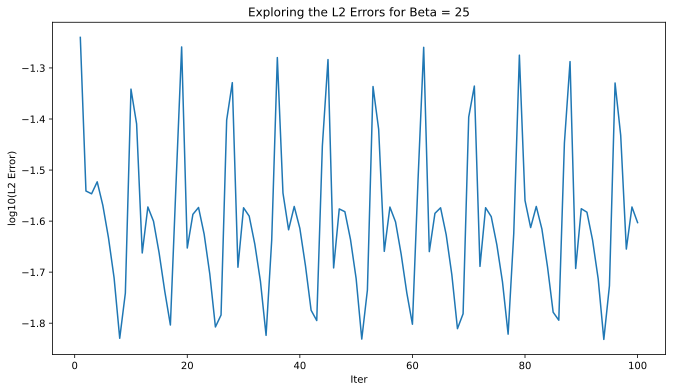

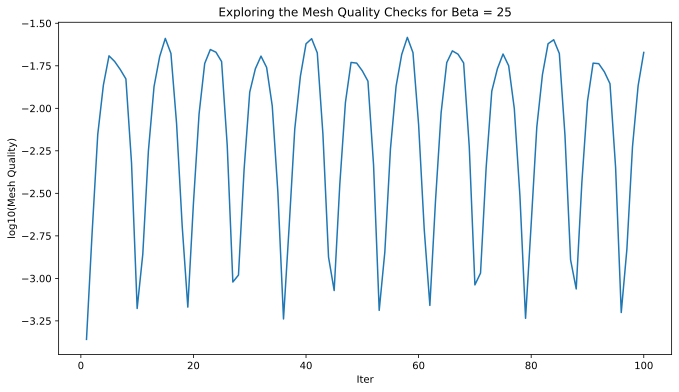



____________________________________________________________________________________________________

beta =  30

____________________________________________________________________________________________________



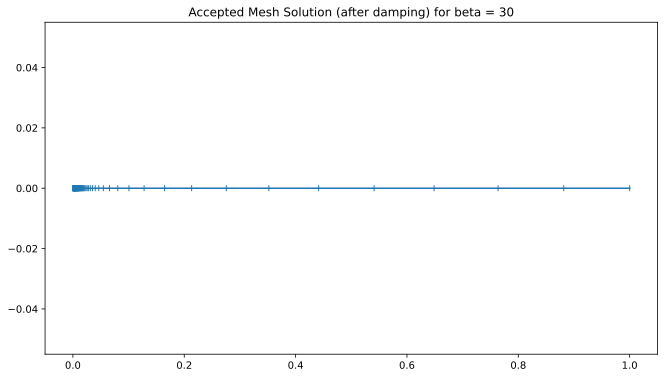

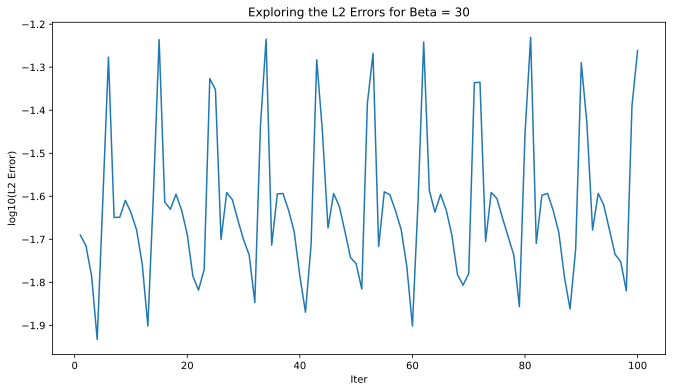

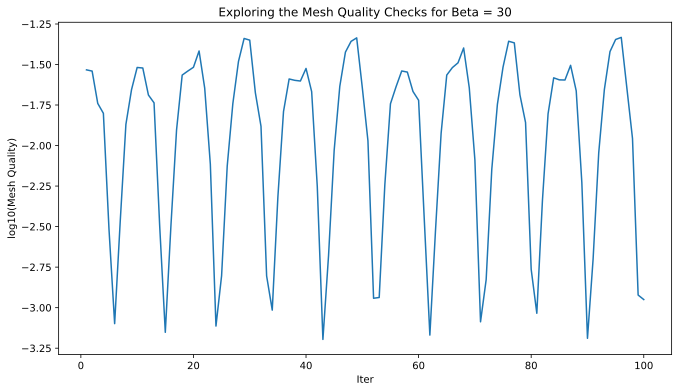



____________________________________________________________________________________________________

beta =  35

____________________________________________________________________________________________________



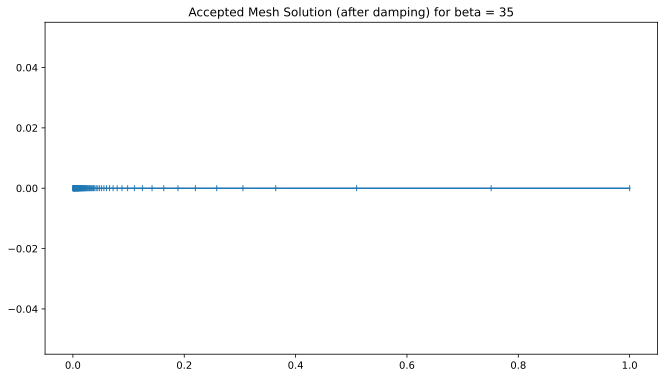

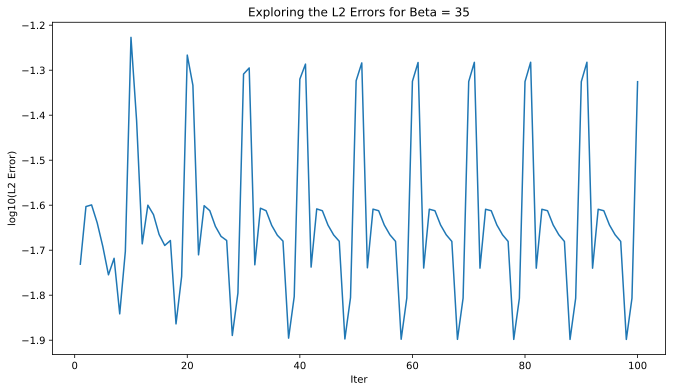

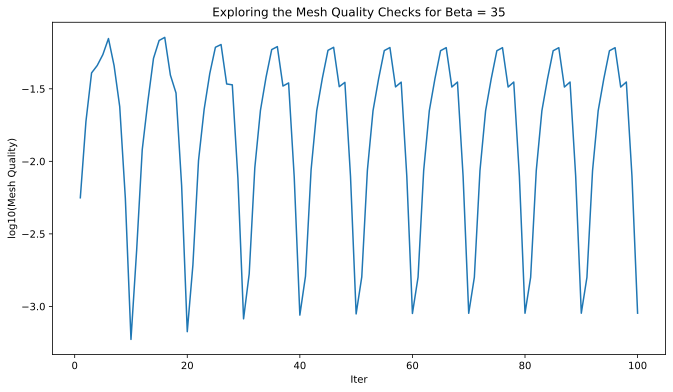



____________________________________________________________________________________________________

beta =  40

____________________________________________________________________________________________________



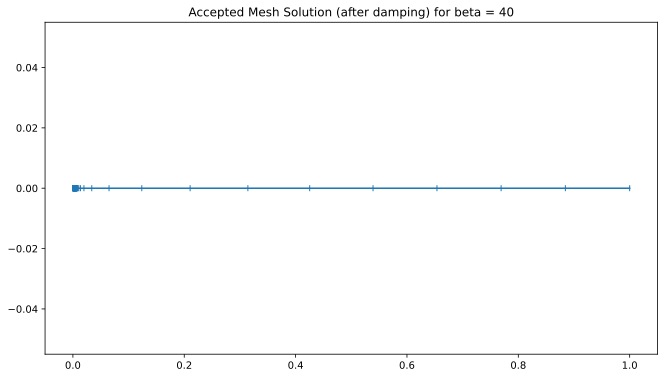

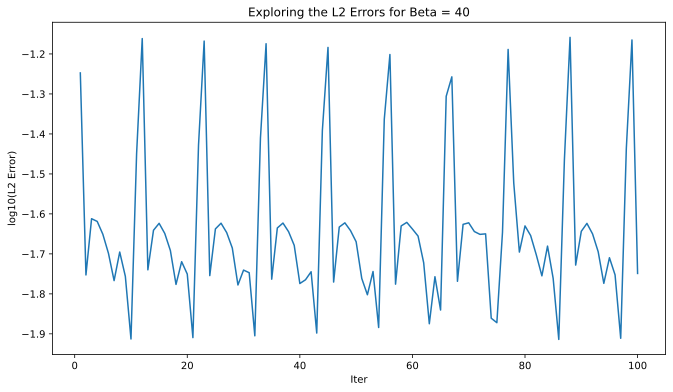

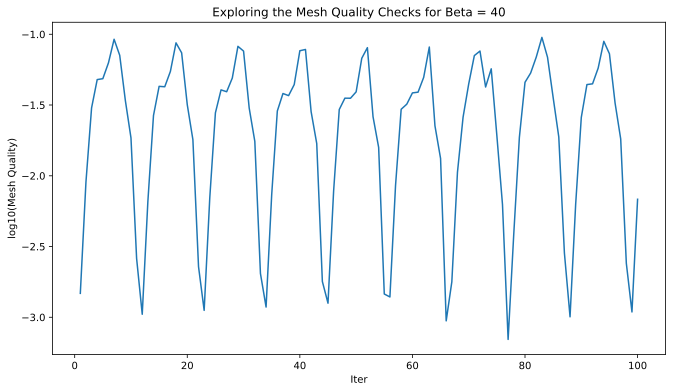



____________________________________________________________________________________________________

beta =  45

____________________________________________________________________________________________________



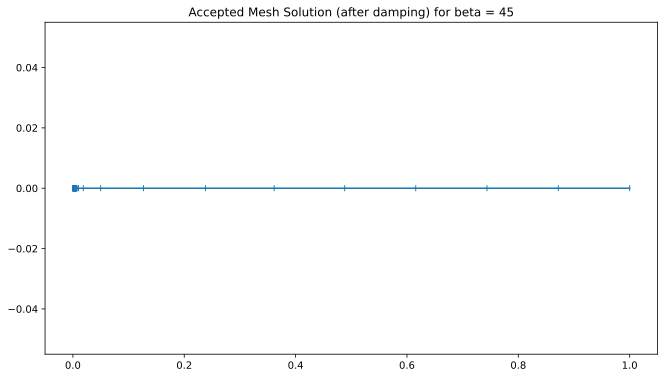

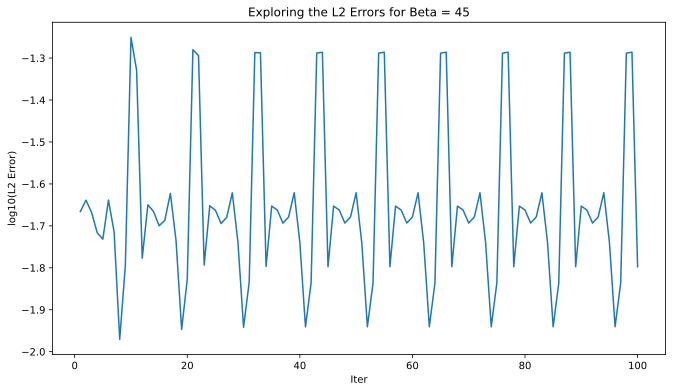

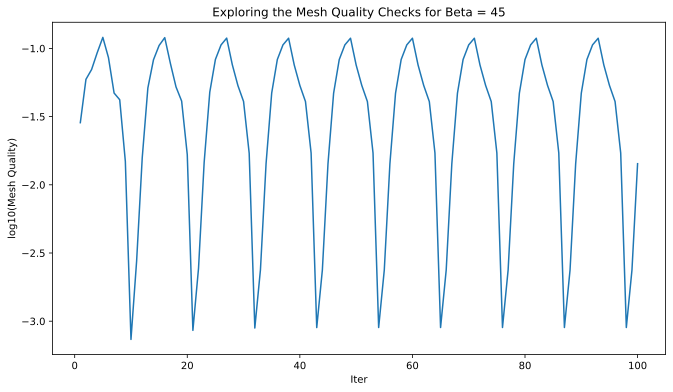



____________________________________________________________________________________________________

beta =  50

____________________________________________________________________________________________________



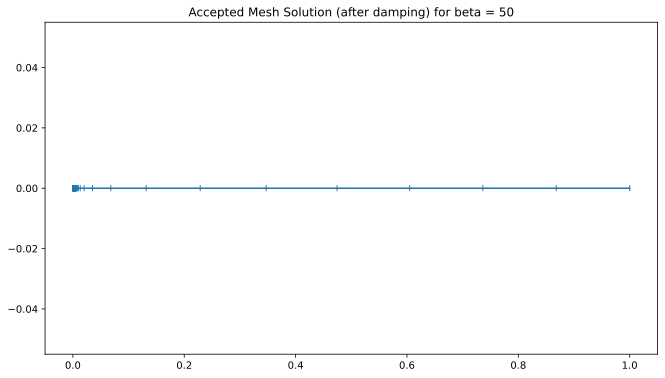

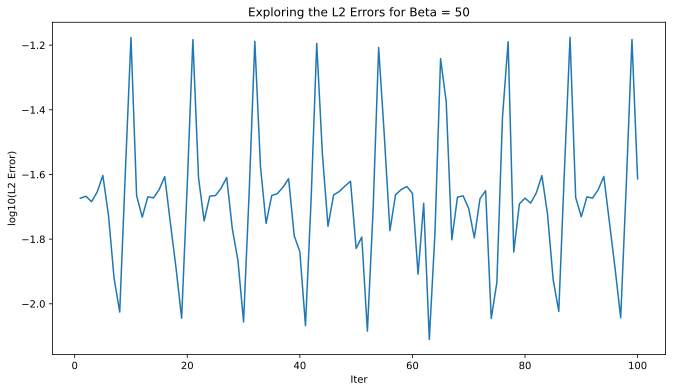

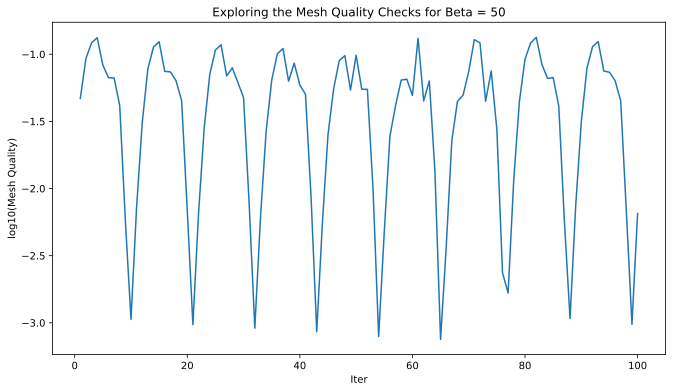

In [4]:
# the setup
N = 100
epsilon = 0.1
# parameter for our exact solution
beta = 0
# damping parameter for piccard iteration
w = 1

# set meshes and function spaces
uni_mesh = UnitIntervalMesh(N)
uni_coord = SpatialCoordinate(uni_mesh)[0]
V = FunctionSpace(uni_mesh, "CG", 1)
W = FunctionSpace(uni_mesh, "CG", 1)
xold = Function(W)
xold.dat.data[:] = uni_mesh.coordinates.dat.data[:]




# while beta < 100:
while beta < 50:

  # update a
  beta = beta + 5

  print()
  print('_'*100)
  print()
  print("beta = ", beta)
  print()
  print('_'*100)
  print()

  # exact solution

  def u_exact(x):
    return np.arctan(beta*x)



  # physical solve

  u = TrialFunction(V) # xi uniform space
  v = TestFunction(V)
  Jx = xold.dx(0) #d x/dxi
  # the problem
  u_deriv = (1/Jx) * u.dx(0) # transform to du/dx
  v_deriv = (1/Jx) * v.dx(0) # transform to dv/dx
  a = (u_deriv * v_deriv ) * Jx * dx # transform dxi to dx
  L = ( (2*beta**3 * xold) / (((beta**2) * xold**2 + 1) ** 2)) * v * Jx * dx #transform dxi to dx
  # BC's
  bcs = [DirichletBC(V, u_exact(0), 1), DirichletBC(V, u_exact(1), 2)]
  # solve
  u = Function(V)
  solve(a==L, u, bcs = bcs)




  # Nonlinear Mesh Solve Given u and M
  # Implement (5) in my notes (nonlinear problem)

  u_interp = atan(beta*xold) # xF is my initial x(xi) = xi


  # list to save consecutive meshes to plot
  mesh_list = []
  # list to save l2 errors
  l2_result = []
  # list to save mesh quality results
  mesh_qual_list = []


  Iter = 100

  for i in range(Iter):


    # Compute M

    # x jacobian
    jacobx = xold.dx(0) #dx/dxi
    # du/dx
    u_deriv = (1/jacobx) * u.dx(0)
    # compute and plot M
    M =  1 + ( u_deriv )**2



    # Mesh Solve



    # set solution and test function
    new_x = Function(W)
    vm = TestFunction(W)

    # jacobian
    Jm = new_x.dx(0) #dx/dxi

    # v'
    v_pr_term = (vm).dx(0)

    # the lhs of the eqn
    F = (M * Jm * v_pr_term) * dx

    # bc's
    bc0 = DirichletBC(W, Constant(0), 1)
    bc1 = DirichletBC(W, Constant(1), 2)
    bcs = [bc0, bc1]

    # initial guess
    new_x.dat.data[:] = xold.dat.data[:]

    # default tolerences : snes_rtol: 1e-8, snes_atol: 1e-50, snes_stol: 1e-8
    solve( F == 0, new_x, bcs = bcs, solver_parameters={'snes_rtol': 1e-8,
                         'snes_atol': 1e-50,
                         'snes_stol': 1e-8})

    # compute the l2 norm of xnew-xold
    l2_check = errornorm(new_x, xold)
    l2_result.append(l2_check)


    # save our new x to the mesh list
    mesh_list.append(new_x)

    # update our x and exact solution
    xold.interpolate( (1-w)*xold + w * new_x )
    u_interp = atan(beta*xold)


    # Physical solve based on this new mesh

    u = TrialFunction(V) # xi uniform space
    v = TestFunction(V)
    J_xnew = new_x.dx(0) #dx/dxi
    # the problem
    u_deriv = (1/J_xnew) * u.dx(0) # transform to du/dx
    v_deriv = (1/J_xnew) * v.dx(0) # transform to dv/dx
    a = (u_deriv * v_deriv ) * J_xnew * dx # transform dxi to dx
    L = ( (2*beta**3 * new_x) / (((beta**2) * new_x**2 + 1) ** 2)) * v * J_xnew * dx #transform dxi to dx
    # BC's
    bcs = [DirichletBC(V, u_exact(0), 1), DirichletBC(V, u_exact(1), 2)]
    # solve
    u = Function(V)
    solve(a==L, u, bcs = bcs)

    # Compute transformed L2 error
    error_val = (u - u_interp)
    mesh_qual = norm(error_val * (sqrt(abs(J_xnew)))) # transform dxi to dx
    mesh_qual_list.append(mesh_qual)



  # plot our final mesh
  plt.plot(xold.dat.data[:], [0 for i in range(N+1)], marker = "|")
  plt.title("Accepted Mesh Solution (after damping) for beta = " + str(beta))
  plt.show()
  print()
  print()


  # compare the l2 errors
  plt.plot([i for i in range(1,Iter+1)], np.log10(l2_result))
  plt.title("Exploring the L2 Errors for Beta = " + str(beta))
  plt.xlabel("Iter")
  plt.ylabel("log10(L2 Error)")
  plt.show()
  print()


  # compare the mesh quality
  plt.plot([i for i in range(1,Iter+1)], np.log10(mesh_qual_list))
  plt.title("Exploring the Mesh Quality Checks for Beta = " + str(beta))
  plt.xlabel("Iter")
  plt.ylabel("log10(Mesh Quality)")
  plt.show()
  print()




